# Position Anomaly Difference

Is the anomaly concentrated on the word that's wrong, or distributed throughout?

In [1]:
import sys
sys.path.append('../')

import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import src.sentpair_generator
import src.anomaly_model

%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Train model

In [2]:
with open('../data/bnc.pkl', 'rb') as f:
  bnc_sentences = pickle.load(f)

random.seed(12345)
bnc_sentences = random.sample(bnc_sentences, 1000)

In [3]:
model = src.anomaly_model.AnomalyModel(bnc_sentences)

In [4]:
sentgen = src.sentpair_generator.SentPairGenerator()

## Pick random sentences

Create a dataset consisting of max 100 sentences from each type, excluding pragmatic ones

In [5]:
for task_name, sent_pair_set in sentgen.get_hand_selected().items():
  print(task_name, len(sent_pair_set.sent_pairs))

BLiMP-SubjVerb 2000
BLiMP-DetNoun 2000
Osterhout-Nicol-Syntactic 90
BLiMP-Animacy 2000
Pylkkanen 70
Warren-Selectional 30
Osterhout-Nicol-Semantic 90
Osterhout-Mobley 90
Warren-Pragmatic 30
CPRAG-34 34
ROLE-88 44
Urbach 120


In [6]:
sent_pairs = []
for _, sent_pair_set in sentgen.get_hand_selected().items():
  if sent_pair_set.category != 'Pragmatic':
    cur_sent_pairs = sent_pair_set.sent_pairs
    if len(cur_sent_pairs) > 100:
      cur_sent_pairs = random.sample(cur_sent_pairs, 100)
    sent_pairs.extend(cur_sent_pairs)

## Compute anomaly difference, by position

In [7]:
LAYER = 11

df = []
for s1, s2 in sent_pairs:
  tokens, all_layer = model.gmm_score([s1, s2])
  tok1 = tokens[0]
  tok2 = tokens[1]
  anom1 = all_layer[0][LAYER]
  anom2 = all_layer[1][LAYER]
  
  # Exclude if they have different number of tokens
  if len(tok1) != len(tok2):
    continue
  
  anom_diff = anom1 - anom2
  
  # Compute position that they differ
  diff_pos = None
  for ix in range(len(tok1)):
    if tok1[ix] != tok2[ix]:
      diff_pos = ix
      break
  
  # Add each token to df
  for ix in range(len(tok1)):
    df.append(pd.Series({
      'tok1': tok1[ix],
      'tok2': tok2[ix],
      'rel_position': ix - diff_pos,
      'anom_diff': anom_diff[ix],
    }))

df = pd.DataFrame(df)

## Make plot

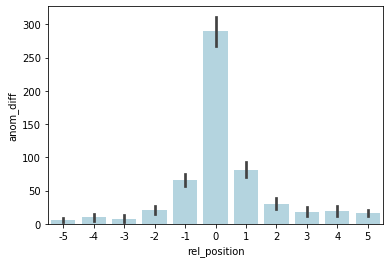

In [12]:
df_filtered = df[(df.rel_position >= -5) & (df.rel_position <= 5)]
sns.barplot(x='rel_position', y='anom_diff', data=df_filtered, color='lightblue')